# **Aspect Based Sentiment Analysis: (3 Classes) - (Laptop + Restaurant) - ABSA Dataset**

### Step 1: Install & Import Dependencies

In [1]:
!pip install -q transformers==4.41.2 peft==0.11.1 accelerate==0.31.0 datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 73.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_auc_score, roc_curve, auc,
    brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

import torch
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback, AutoConfig
)
from peft import LoraConfig, TaskType, get_peft_model

### Step 2: Mount Google Drive & Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

file_path = "/content/drive/MyDrive/Laptop + Restaurant - ABSA.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df[['Text', 'Sentiment']].dropna()
df.head()

Mounted at /content/drive


,Text,Sentiment
0,I charge it at night and skip taking the cord ...,Positive
1,The tech guy then said the service center does...,Negative
2,The tech guy then said the service center does...,Negative
3,The tech guy then said the service center does...,Neutral
4,"it is of high quality, has a killer GUI, is ex...",Positive


In [4]:
total_instances = len(df)
print(f"Total instances: {total_instances}")

sentiment_counts = df['Sentiment'].value_counts()
print("Number of instances per sentiment:")
print(sentiment_counts)

Total instances: 5914
Number of instances per sentiment:
Sentiment
Positive    3151
Negative    1671
Neutral     1092
Name: count, dtype: int64


### Step 3: Visualize Dataset Distribution

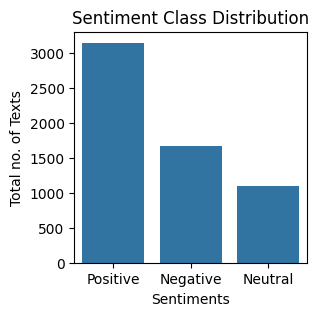

In [5]:
plt.figure(figsize=(3,3))
sns.countplot(data=df, x='Sentiment')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiments")
plt.ylabel("Total no. of Texts")
plt.grid(False)
plt.show()


### Step 4: Encode Labels

In [6]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])

print("Label Mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


Label Mapping:
Negative: 0
Neutral: 1
Positive: 2


### Step 5: Train-Test Split

In [7]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['Text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}, Test size: {len(test_texts)}")

Train size: 4731, Val size: 591, Test size: 592


### Step 6: Tokenization

In [8]:
base_model_name = "microsoft/deberta-v3-base"
finetuned_model_name = "yangheng/deberta-v3-base-absa-v1.1"
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings  = tokenizer(test_texts, truncation=True, padding=True, max_length=512)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


### Step 7: Dataset Class

In [9]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset   = SentimentDataset(val_encodings, val_labels)
test_dataset  = SentimentDataset(test_encodings, test_labels)

### Step 8: Define Metrics Function

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    proba = torch.softmax(torch.tensor(logits), dim=-1).numpy()

    acc = accuracy_score(labels, preds) * 100

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    sims = []
    for i in range(len(labels)):
        true_onehot = np.zeros(proba.shape[1])
        true_onehot[labels[i]] = 1
        sims.append(cosine_similarity([true_onehot], [proba[i]])[0][0])
    similarity_score = np.mean(sims) * 100

    confidence_score = np.mean(np.max(proba, axis=1)) * 100

    return {
        "eval_Accuracy": acc,
        "eval_Precision": prec * 100,
        "eval_Recall": rec * 100,
        "eval_F1 Score": f1 * 100,
        "eval_Similarity Score": similarity_score,
        "eval_Confidence Score": confidence_score
    }


### Step 9: Evaluate Without Fine-Tuning

In [11]:
baseline_model = AutoModelForSequenceClassification.from_pretrained(finetuned_model_name)

baseline_trainer = Trainer(
    model=baseline_model,
    args=TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=32
    ),
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

baseline_metrics = baseline_trainer.evaluate()

print("\n===== Performance of Pretrained Transformer Model =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in baseline_metrics:
        print(f"{metric} is: {baseline_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {baseline_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {baseline_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {baseline_metrics.get('eval_samples_per_second', 0.0)}")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: usman-muhammad1471 (usman-muhammad1471-eotvos-lorand-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



===== Performance of Pretrained Transformer Model =====

Accuracy is: 75.84%
Precision is: 71.05%
Recall is: 73.23%
F1 Score is: 71.84%
Similarity Score is: 80.38%
Confidence Score is: 78.00%

===== Evaluation Details =====
Eval Loss: 0.5917
Runtime: 4.4436 sec
Samples per second: 133.224


### Step 9.1: Confusion Matrix (Without Fine-Tuning)

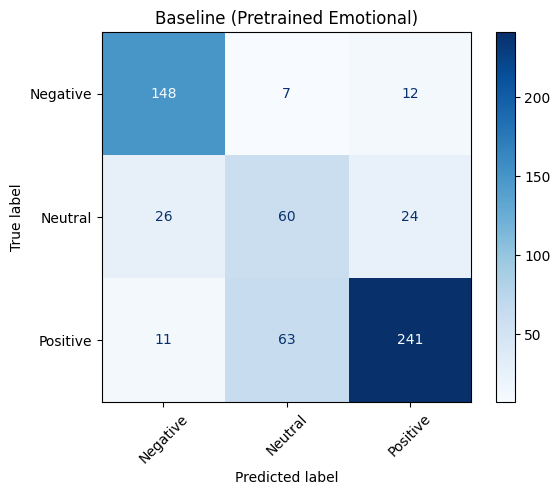

In [12]:
preds = baseline_trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = label_encoder.classes_

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Baseline (Pretrained Emotional)")
plt.show()

### Step 10: Base Model Fine-Tuning Configuration & Training

In [13]:
config = AutoConfig.from_pretrained(
    base_model_name,
    num_labels=len(label_encoder.classes_),
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3,
    classifier_dropout=0.2
)

model_base = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    config=config
)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.1,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="epoch",
    report_to="none",
    fp16=True,
    gradient_accumulation_steps=1,
    save_total_limit=2,
    max_grad_norm=1.0,
    lr_scheduler_type="linear",
    seed=42,
    dataloader_pin_memory=False,
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3),
    ]
)

trainer_base.train()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
1,0.876800,0.631939,74.957699,66.106800,62.844755,61.125152,79.454358,80.287842
2,0.628500,0.654099,76.649746,70.637175,67.058735,67.710118,79.999899,86.723854
3,0.546000,0.641489,79.864636,75.001607,73.344815,73.342529,81.882372,88.874275
4,0.488800,0.664486,79.187817,73.923517,73.721495,73.377238,81.085231,90.210876


TrainOutput(global_step=2368, training_loss=0.6350576426531818, metrics={'train_runtime': 533.9477, 'train_samples_per_second': 44.302, 'train_steps_per_second': 5.544, 'total_flos': 894708555230880.0, 'train_loss': 0.6350576426531818, 'epoch': 4.0})

#### Step 10.1: Fine-Tuned Base Model Evaluation & Performance Analysis

In [14]:
finetuned_metrics = trainer_base.evaluate(test_dataset)

print("\n===== Performance after Fine-Tuning Base Model =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in finetuned_metrics:
        print(f"{metric} is: {finetuned_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {finetuned_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {finetuned_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {finetuned_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance after Fine-Tuning Base Model =====

Accuracy is: 78.04%
Precision is: 71.85%
Recall is: 67.80%
F1 Score is: 66.74%
Similarity Score is: 81.80%
Confidence Score is: 80.09%

===== Evaluation Details =====
Eval Loss: 0.5682
Runtime: 1.5713 sec
Samples per second: 376.762


#### Step 10.2: Confusion Matrix Analysis

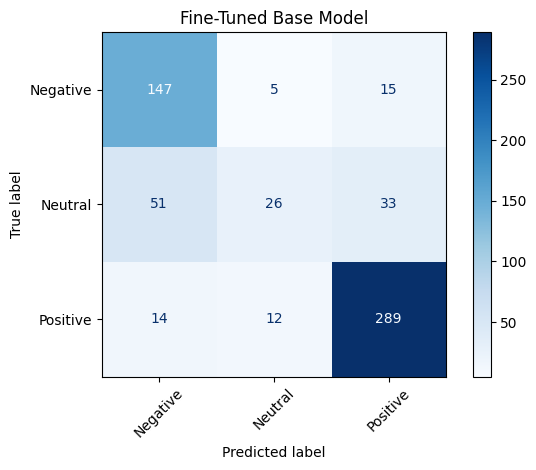

In [15]:
preds = trainer_base.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)

class_names = label_encoder.classes_

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(
    cmap="Blues",
    xticks_rotation=45
)
plt.title("Fine-Tuned Base Model")
plt.tight_layout()
plt.show()

#### Step 10.3: Training Progress Visualization & Loss Analysis

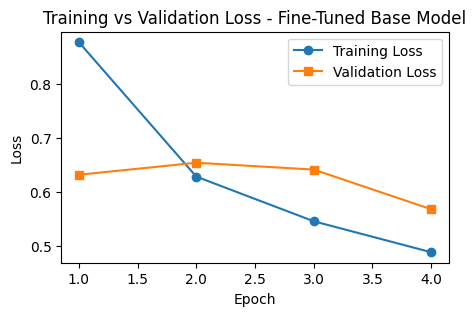

In [16]:
logs_base = trainer_base.state.log_history

train_loss_base = {}
eval_loss_base = {}

for log in logs_base:
    if "loss" in log and "epoch" in log:
        train_loss_base[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_base[float(log["epoch"])] = log["eval_loss"]

epochs_base = sorted(set(train_loss_base.keys()) | set(eval_loss_base.keys()))
train_vals_base = [train_loss_base.get(e, None) for e in epochs_base]
eval_vals_base = [eval_loss_base.get(e, None) for e in epochs_base]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_base, train_vals_base, label="Training Loss", marker="o")
plt.plot(epochs_base, eval_vals_base, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Fine-Tuned Base Model")
plt.legend()
plt.grid(False)
plt.show()


### Step 11: Adapter (LoRA) Model Configuration & Training

In [17]:
adapter_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=len(label_encoder.classes_)
)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.2,
    target_modules=["query_proj", "key_proj", "value_proj", "output.dense"],
    bias="none",
    modules_to_save=["classifier"]
)

adapter_model = get_peft_model(adapter_model, peft_config)

adapter_model.print_trainable_parameters()

adapter_args = TrainingArguments(
    output_dir="./results-adapter",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=12,
    weight_decay=0.05,
    warmup_ratio=0.1,
    logging_dir="./logs-adapter",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    seed=42,
    fp16=True,
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
    logging_steps=50,
    save_total_limit=2,
    lr_scheduler_type="cosine",
    dataloader_pin_memory=False,
    remove_unused_columns=True
)

trainer_adapter = Trainer(
    model=adapter_model,
    args=adapter_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=4),
    ]
)

print("Training DeBERTa-v3-base with LoRA for small dataset...")
trainer_adapter.train()

adapter_metrics = trainer_adapter.evaluate(test_dataset)
print("Performance with Adapter (LoRA):", adapter_metrics)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:477: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


trainable params: 1,919,235 || all params: 186,343,686 || trainable%: 1.0299
Training DeBERTa-v3-base with LoRA for small dataset...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 score,Similarity score,Confidence score
1,0.881500,0.688819,73.773266,47.786877,59.735767,52.910229,77.524382,74.365471
2,0.640000,0.703866,73.942470,64.624625,62.146562,62.463876,78.177271,85.351097
3,0.548800,0.606901,78.003384,72.457926,68.517696,69.501656,81.020399,87.086456
4,0.488400,0.599718,78.510998,72.591439,70.241867,70.465894,81.584263,87.430000
5,0.446500,0.621742,77.664975,72.587571,69.274371,70.501738,80.698817,89.278381
6,0.414700,0.648644,77.664975,71.797850,69.306007,70.132075,80.889070,91.042534
7,0.373200,0.721940,77.834179,71.827663,69.386969,70.071243,80.300251,92.685043
8,0.359000,0.705421,77.157360,71.486987,69.894718,70.523633,80.197679,92.118172


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is dep

Performance with Adapter (LoRA): {'eval_Accuracy': 79.22297297297297, 'eval_Precision': 77.05783099508369, 'eval_Recall': 72.53259714337558, 'eval_F1 Score': 71.99724629266225, 'eval_Similarity Score': 81.68802326631743, 'eval_Confidence Score': 87.5724105834961, 'eval_loss': 0.6069816946983337, 'eval_runtime': 1.9982, 'eval_samples_per_second': 296.273, 'eval_steps_per_second': 18.517, 'epoch': 8.0}


#### Step 11.1: Adapter (LoRA) Model Evaluation & Performance Analysis

In [18]:
adapter_metrics = trainer_adapter.evaluate(test_dataset)

print("\n===== Performance with Adapter (LoRA) =====\n")

metrics_to_show = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "Similarity Score",
    "Confidence Score"
]

for metric in metrics_to_show:
    key = f"eval_{metric}"
    if key in adapter_metrics:
        print(f"{metric} is: {adapter_metrics[key]:.2f}%")

print("\n===== Evaluation Details =====")
print(f"Eval Loss: {adapter_metrics.get('eval_loss', 0.0):.4f}")
print(f"Runtime: {adapter_metrics.get('eval_runtime', 0.0)} sec")
print(f"Samples per second: {adapter_metrics.get('eval_samples_per_second', 0.0)}")



===== Performance with Adapter (LoRA) =====

Accuracy is: 79.22%
Precision is: 77.06%
Recall is: 72.53%
F1 Score is: 72.00%
Similarity Score is: 81.69%
Confidence Score is: 87.57%

===== Evaluation Details =====
Eval Loss: 0.6070
Runtime: 2.079 sec
Samples per second: 284.754


#### Step 11.2: Confusion Matrix Analysis

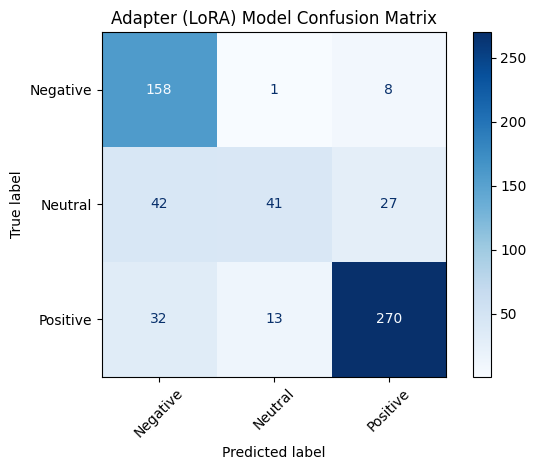

In [19]:
preds = trainer_adapter.predict(test_dataset)
y_true, y_pred = preds.label_ids, preds.predictions.argmax(-1)
cm = confusion_matrix(y_true, y_pred)
class_names = label_encoder.classes_
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
plt.title("Adapter (LoRA) Model Confusion Matrix")
plt.tight_layout()
plt.show()

#### Step 11.3: Training Progress Visualization & Loss Analysis

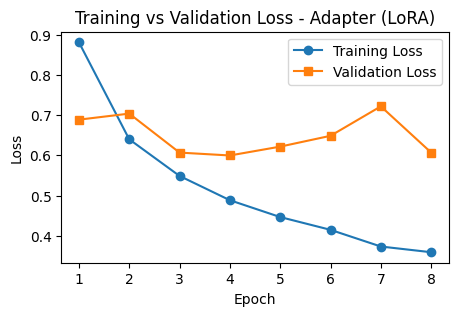

In [20]:
 logs_adapter = trainer_adapter.state.log_history

train_loss_adapter = {}
eval_loss_adapter = {}

for log in logs_adapter:
    if "loss" in log and "epoch" in log:
        train_loss_adapter[float(log["epoch"])] = log["loss"]
    if "eval_loss" in log and "epoch" in log:
        eval_loss_adapter[float(log["epoch"])] = log["eval_loss"]

epochs_adapter = sorted(set(train_loss_adapter.keys()) | set(eval_loss_adapter.keys()))
train_vals_adapter = [train_loss_adapter.get(e, None) for e in epochs_adapter]
eval_vals_adapter = [eval_loss_adapter.get(e, None) for e in epochs_adapter]

# Plot
plt.figure(figsize=(5,3))
plt.plot(epochs_adapter, train_vals_adapter, label="Training Loss", marker="o")
plt.plot(epochs_adapter, eval_vals_adapter, label="Validation Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss - Adapter (LoRA)")
plt.legend()
plt.grid(False)
plt.show()


### Step 12: Comprehensive Model Comparison & Performance Visualization

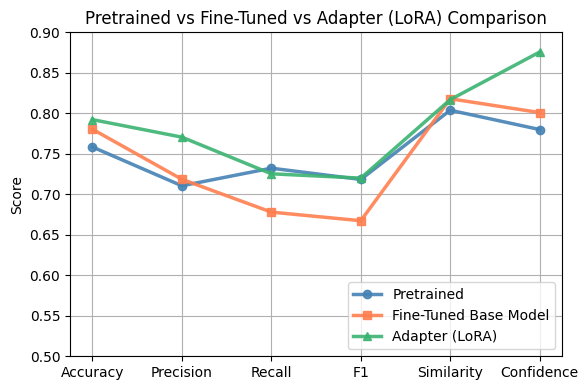

In [28]:
metrics = ["Accuracy", "Precision", "Recall", "F1", "Similarity", "Confidence"]

pretrained_vals = np.array([baseline_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
base_vals = np.array([finetuned_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100
adapter_vals = np.array([adapter_metrics[f"eval_{m}"] for m in ["Accuracy", "Precision", "Recall", "F1 Score", "Similarity Score", "Confidence Score"]]) / 100

x = np.arange(len(metrics))

plt.figure(figsize=(6, 4))

plt.plot(x, pretrained_vals, marker='o', linestyle='-', linewidth=2.5, alpha=0.9, label="Pretrained", color='steelblue')
plt.plot(x, base_vals, marker='s', linestyle='-', linewidth=2.5, alpha=0.9, label="Fine-Tuned Base Model", color='coral')
plt.plot(x, adapter_vals, marker='^', linestyle='-', linewidth=2.5, alpha=0.9, label="Adapter (LoRA)", color='mediumseagreen')

plt.xticks(x, metrics, fontsize=10)
plt.ylabel("Score")
plt.ylim(0.50, 0.90)
plt.title("Pretrained vs Fine-Tuned vs Adapter (LoRA) Comparison")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()